## Outlier Engineering

We will see how to perform capping with the **gaussian approximation** using the Boston House Dataset!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  # for Q-Q plots
from sklearn.datasets import load_boston
from feature_engine.outliers import Winsorizer

**Load the the Boston House price data from sklearn! Create a dataframe with the independent variables!**

In [2]:
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data,
    columns=boston_dataset.feature_names)[['RM', 'LSTAT', 'CRIM']]
boston['MEDV'] = boston_dataset.target  # add the target
boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


**The function to create histogram, Q-Q plot and boxplot!**

In [3]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 4))  # define figure size
    plt.subplot(1, 3, 1)  # histogram
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')
    plt.subplot(1, 3, 2)  # Q-Q plot
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.subplot(1, 3, 3)  # boxplot
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

**Find outliers in RM !**

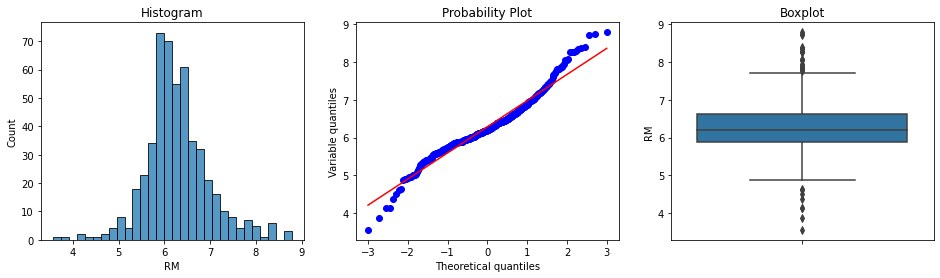

In [4]:
diagnostic_plots(boston, 'RM')

**Visualise outliers in LSTAT !**

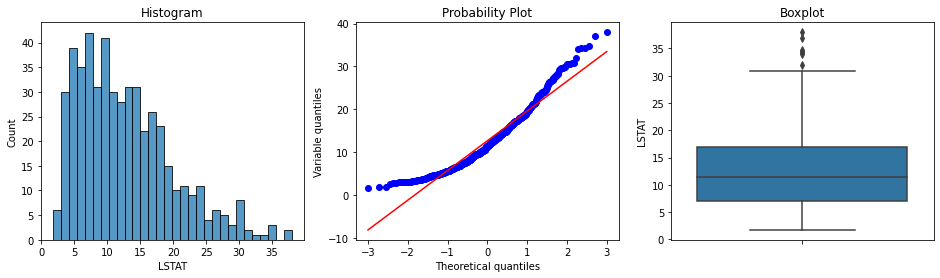

In [5]:
diagnostic_plots(boston, 'LSTAT')

**Outliers in CRIM !**

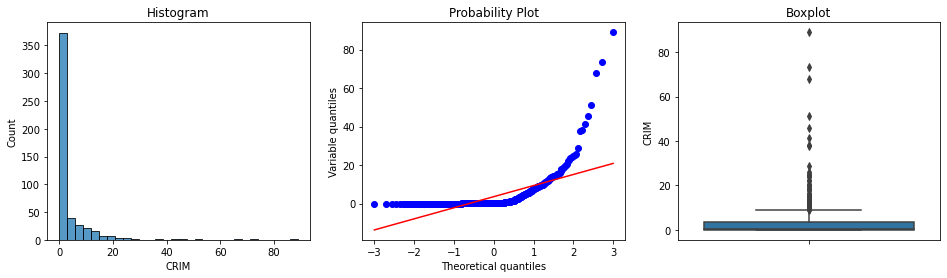

In [6]:
diagnostic_plots(boston, 'CRIM')

There are outliers in all of the above variables. RM shows outliers in both tails, whereas LSTAT and CRIM only on the right tail.

**To find the outliers, let's re-utilise the function that calculate the boundaries outside which sit the outliers for a Gaussian distribution!**

In [7]:
def find_normal_boundaries(df, variable, distance):
    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()
    return upper_boundary, lower_boundary

**Find limits for RM !**

In [8]:
RM_upper_limit, RM_lower_limit = find_normal_boundaries(boston, 'RM', 3)
RM_upper_limit, RM_lower_limit

(8.392485817597757, 4.176782957105816)

**Limits for LSTAT !**

In [9]:
LSTAT_upper_limit, LSTAT_lower_limit = find_normal_boundaries(boston, 'LSTAT', 3)
LSTAT_upper_limit, LSTAT_lower_limit

(34.07624777515244, -8.77012129293899)

**Limits for CRIM !**

In [10]:
CRIM_upper_limit, CRIM_lower_limit = find_normal_boundaries(boston, 'CRIM', 3)
CRIM_upper_limit, CRIM_lower_limit

(29.418158873309714, -22.19111175868521)

**Replace the outliers by the maximum and minimum limit!**

In [11]:
boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
    np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

**Replace the outliers by the maximum and minimum limit!**

In [12]:
boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
    np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

**Replace the outliers by the maximum and minimum limit!**

In [13]:
boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
     np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

**Explore outliers in the trimmed dataset! For RM we see much less outliers as in the original dataset!**

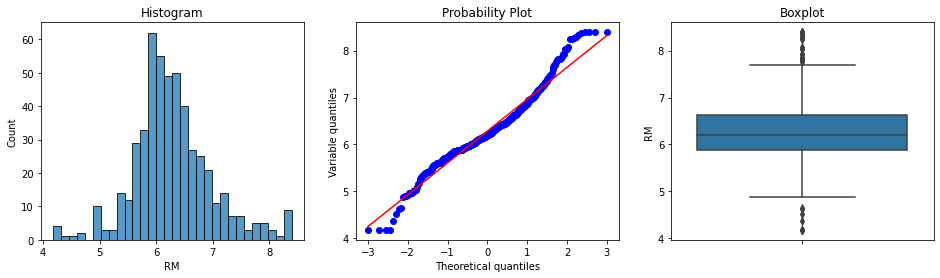

In [14]:
diagnostic_plots(boston, 'RM')

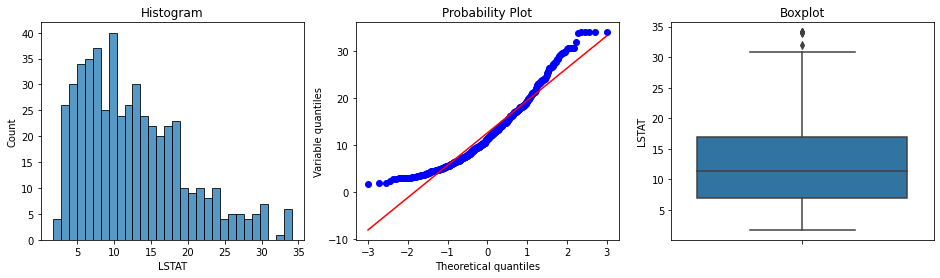

In [15]:
diagnostic_plots(boston, 'LSTAT')

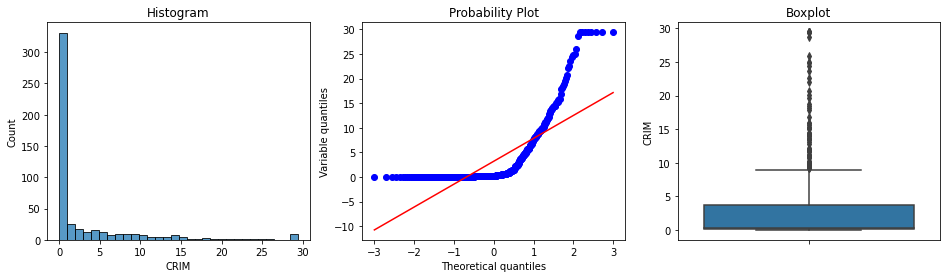

In [16]:
diagnostic_plots(boston, 'CRIM')

**None of these variables are normally distributed,** that is probably why the Gaussian approximation was not so effective to remove outliers. **We could try and use a smaller distance, instead of multiplying by 3 times the std**, we could **2 times or 1.5.** But those numbers are set **arbitrarily**, and do **not pose much statistical sense**, therefore defeating the point of using the Gaussian approximation. If this capping does not work as desired, use the **IQR rule**, or quantiles!

## Censoring with feature-engine

**Load the the Boston House price data from sklearn! Create a dataframe with the independent variables!**

In [17]:
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data,
    columns=boston_dataset.feature_names)[['RM', 'LSTAT', 'CRIM']]
boston['MEDV'] = boston_dataset.target   # add the target
boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


**Create the capper!**

In [18]:
windsoriser = Winsorizer(capping_method='gaussian', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RM', 'LSTAT', 'CRIM'])
windsoriser.fit(boston)

Winsorizer(tail='both', variables=['RM', 'LSTAT', 'CRIM'])

In [19]:
boston_t = windsoriser.transform(boston)

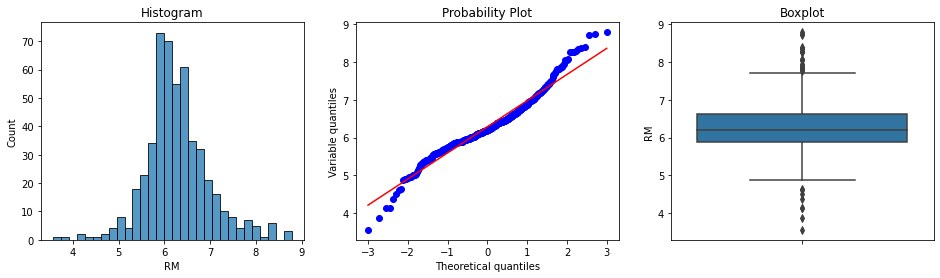

In [20]:
diagnostic_plots(boston, 'RM')

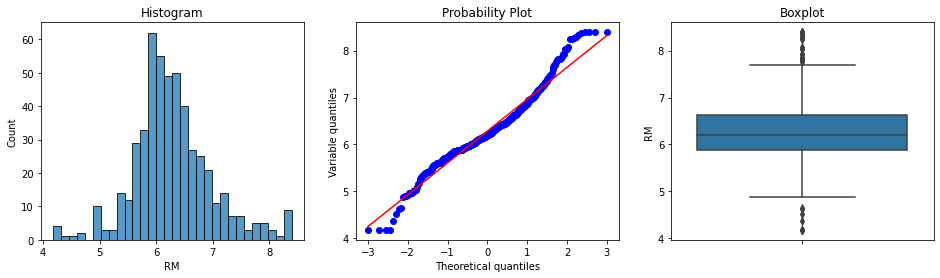

In [21]:
diagnostic_plots(boston_t, 'RM')

**Inspect the minimum caps for each variable!**

In [22]:
windsoriser.left_tail_caps_

{'RM': 4.176782957105816,
 'LSTAT': -8.77012129293899,
 'CRIM': -22.19111175868521}

**Inspect the maximum caps for each variable!**

In [23]:
windsoriser.right_tail_caps_

{'RM': 8.392485817597757,
 'LSTAT': 34.07624777515244,
 'CRIM': 29.418158873309714}

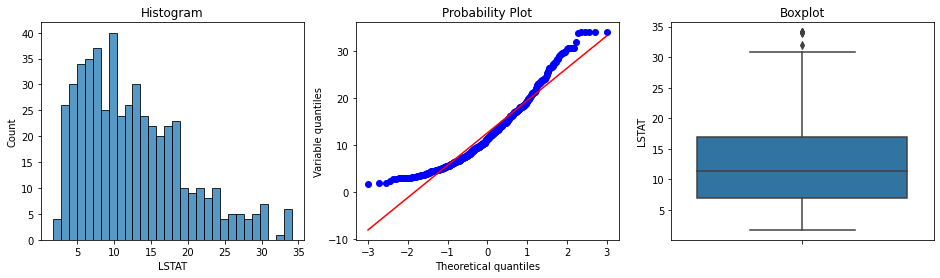

In [24]:
diagnostic_plots(boston_t, 'LSTAT')

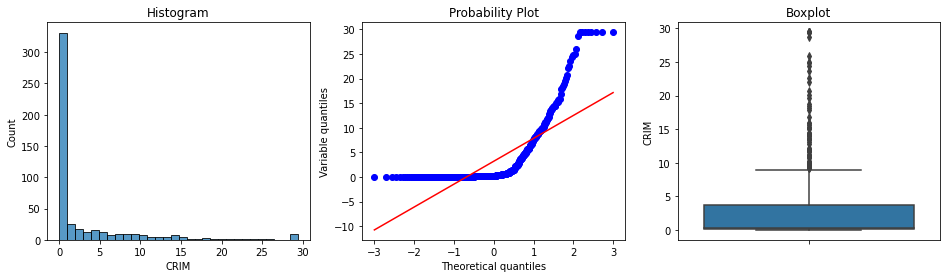

In [25]:
diagnostic_plots(boston_t, 'CRIM')

**None of these variables are normally distributed,** that is probably why the Gaussian approximation was not so effective to remove outliers. **We could try and use a smaller distance, instead of multiplying by 3 times the std**, we could **2 times or 1.5.** But those numbers are set **arbitrarily**, and do **not pose much statistical sense**, therefore defeating the point of using the Gaussian approximation. If this capping does not work as desired, use the **IQR rule**, or quantiles!